## Capston Project - Regulating Vacation Listings

In [1]:
#import libraries
import numpy as np
import pandas as pd
#Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
rs = 42



## Collecting Data

In [2]:
#importing dataset
files_dir = "../dataset/"
filename_original = files_dir + "AB_NYC_2019.csv"
df_2019 = pd.read_csv(filename_original)
#filename = files_dir + "AB_NYC_2019.csv"
filename = files_dir + "listings.csv"
df_more = pd.read_csv(filename)
df_more.drop([ 'number_of_reviews_ltm'], axis=1, inplace=True)
df_2019 = df_2019.drop_duplicates(subset = ['id'], inplace=False).copy()
df_more = df_more.drop_duplicates(subset = ['id'], inplace=False).copy()
other_data= df_more[~ df_more.id.isin(df_2019.id)]
df_concat = pd.concat([df_2019, other_data], axis=0, ignore_index=True)
#df_concat.to_csv('concatenated_data.csv', index=False)

## Pre-processing the data



In [3]:
def scaler_transform(scaler_type, X, exclude_vars = ['latitude', 'longitude', 'id','NG_Brooklyn','NG_Manhattan','NG_Queens','NG_Bronx','NG_Staten Island','room_type_Private room','room_type_Shared room']):
    '''
    Transform the NON-object type data to the selected scaler
    '''
    X_copy = X.copy(deep = True)
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    X_notexcluded= X_copy.loc[:, ~X_copy.columns.isin(exclude_vars)]
    X_withoutobj = X_notexcluded.select_dtypes(exclude=['object'])
    #X_withoutobj = X_withoutobj.add_suffix(f'_{scaler_type}')
    # Fit transform the scaler if there are objects in dataset
    if X_withoutobj.shape[1] > 0:
        X_withoutobj = pd.DataFrame(scaler.fit_transform(X_withoutobj[X_withoutobj.columns]),
                                        index=X_withoutobj.index,
                                        columns=X_withoutobj.columns)
        # Concatenate the rest of the data
        X_withexcl = pd.concat([X_withoutobj, X.loc[:, X.columns.isin(exclude_vars)]], axis=1)
        others = [x for x in X.select_dtypes('object') if x not in X_withexcl.columns]
        X_final = pd.concat([X_withexcl,X[others]], axis=1)
    return X_final, scaler

In [6]:
#drop duplicates
df_duplicates = df_concat.drop_duplicates(subset = ['id'], inplace=False).copy()
#df_duplicates = df_2019.drop_duplicates(subset = ['id'], inplace=False).copy()
#data types
df_duplicates['id'] = df_duplicates['id'].fillna(0)
df_duplicates['id'] = df_duplicates['id'].astype(int)
df_duplicates['host_id'] = df_duplicates['host_id'].fillna(0)
df_duplicates['host_id'] = df_duplicates['host_id'].astype(int)
#missing data 
df_missing = df_duplicates.copy(deep=True)
#dropping irrelevant columns
df_missing.drop(['host_id','host_name'], axis=1, inplace=True)
#replacing missing values
df_missing[(df_missing.last_review.isnull()) & (df_missing.reviews_per_month.isnull())] = df_missing[(df_missing.last_review.isnull()) & (df_missing.reviews_per_month.isnull())].replace(np.nan,0)
#dropping irrelevant columns
df_missing.drop(['last_review'], axis=1, inplace=True)
#dropping rows with NaN in listing names
df_missing.dropna(subset = ['name'], inplace= True)
#feature encoding
df_encode = df_missing.copy(deep=True)
df_encode['room_type']=pd.factorize(df_encode.room_type)[0]
df_dummies = pd.get_dummies(df_encode, columns = ['neighbourhood_group'],
                                          prefix = 'NG',drop_first=True)
df_dummies.drop(['neighbourhood'], axis=1, inplace=True)
#truncate minimum nights
from scipy.stats.mstats import winsorize
df_win = df_dummies.copy(deep=True)
df_win['minimum_nights'] = winsorize(df_win['minimum_nights'], limits=(0, 0.075))
df_win['price'] = winsorize(df_win['price'], limits=(0, 0.03))
#integrate the geodata dataframe
geodata = pd.read_csv('../dataset/merged_map.csv')
geodata_sub = pd.read_csv('../dataset/subway_data.csv')
df_all = df_win.copy()
df_all= df_all.merge(geodata, left_on = 'id', right_on = 'id')
df_all = df_all.merge(geodata_sub, left_on = 'id', right_on = 'id')
df_all.drop(['geom_x','geom_y'], axis=1, inplace=True)
df_all.to_csv('df_clean_send.csv', index=False)

In [7]:
df_all.shape

(48800, 19)

In [8]:
# Set the global default size of matplotlib figures
import matplotlib.pyplot as plt
import seaborn   as sns
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
rc = {'figure.figsize':(8,6),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'grid.color': '.8',
      'font.family':'Times New Roman',
      'font.size' : 30,
      'xtick.labelsize' :30,
      'ytick.labelsize' : 30}
plt.rcParams.update(rc)

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


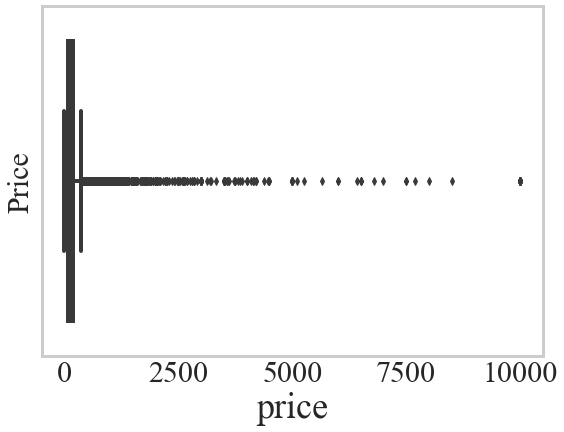

In [9]:
sns.boxplot((df_dummies['price']), color= 'm')
plt.title('')
plt.ylabel('Price', fontsize = 30)
plt.show()

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


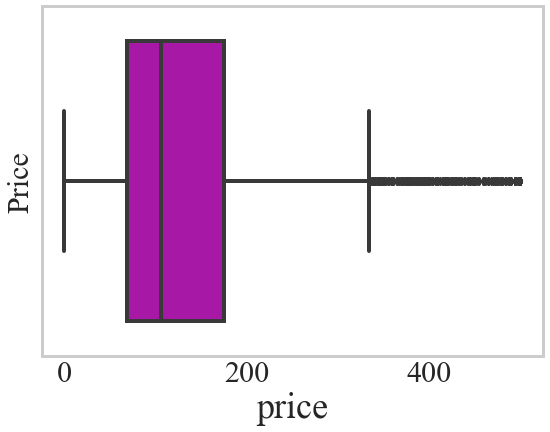

In [10]:
sns.boxplot((df_all['price']), color= 'm')
plt.title('')
plt.ylabel('Price', fontsize = 30)
plt.show()

## Additional Transformations 


In [11]:
#to remove the skeweness of the price we log transform the price 
df_log = df_all.copy(deep=True)
df_log['price'] =  np.log1p(df_log['price'])


/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Original Price Distribution Plot')

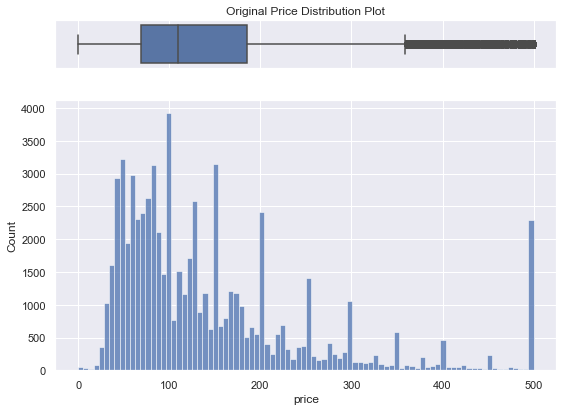

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
def hist_box_plot(df, col):
	sns.set(style="darkgrid")
	f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
	sns.boxplot(df[col], ax=ax_box)
	sns.histplot(data=df[col], ax=ax_hist)
	ax_box.set(xlabel='')
	return ax_box
ax_box = hist_box_plot(df_win, 'price')
ax_box.set_title('Original Price Distribution Plot')




/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Transformed Price Distribution Plot')

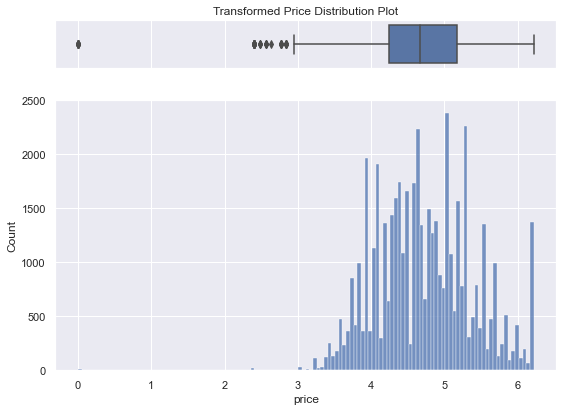

In [13]:
ax_box = hist_box_plot(np.log1p(pd.DataFrame(df_all['price']).reset_index().drop(['index'], axis=1)), 'price')
ax_box.set_title('Transformed Price Distribution Plot')

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Price Transformed ')]

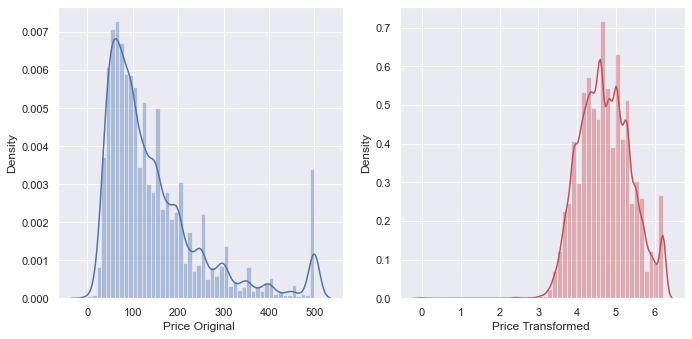

In [14]:

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1 = sns.distplot(df_win['price'], ax=axes[0])
ax1.set(xlabel='Price Original ')
sns.set_palette("Paired")
ax2 = sns.distplot(np.log1p(pd.DataFrame(df_all['price']).reset_index().drop(['index'], axis=1)), ax=axes[1], color = 'r')
ax2.set(xlabel='Price Transformed ')

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


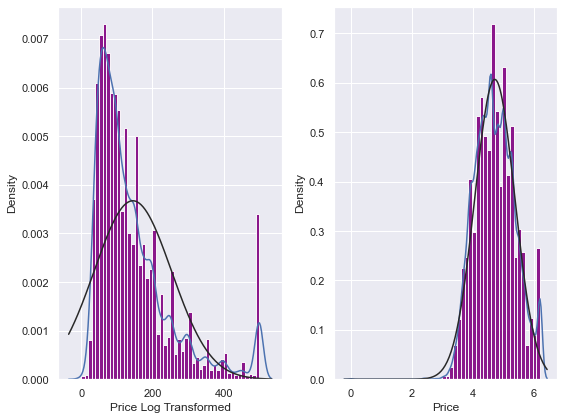

In [15]:
from scipy.stats import norm
rows = 1
cols = 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, frameon= False)
plt.subplots_adjust(left=None, bottom=None, right=None, top= 0.8, wspace=0.3 , hspace=0.3)


g4  = sns.distplot(x = df_win['price'], ax=axes[0], fit = norm, kde = True, bins = 50, color = 'b', hist_kws = {'color':'purple', 'alpha':0.9})

g5  = sns.distplot(x = df_log['price'], ax=axes[1],fit = norm, kde = True, bins = 50, color = 'b', hist_kws = {'color':'purple', 'alpha':0.9})

axes[1].set_xlabel('Price')
axes[0].set_xlabel('Price Log Transformed')
axes[0].set_ylabel('Density')
axes[1].set_ylabel('Density')
plt.tight_layout() 
plt.show()

In [16]:
#here check which dont have data 
df_log.isna().sum()

id                                0
name                              0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
NG_Brooklyn                       0
NG_Manhattan                      0
NG_Queens                         0
NG_Staten Island                  0
amenities_500                     0
leisure_500                       0
subway_500                        0
natural_500                       0
dtype: int64

In [17]:
#scale the numeric features 
df_std = df_log.copy(deep=True)
df_std, scaler = scaler_transform('standard', df_std, exclude_vars = ['price','latitude', 'longitude', 'id','NG_Brooklyn','NG_Manhattan','NG_Queens','NG_Bronx','NG_Staten Island','room_type_Private room','room_type_Shared room'])

In [18]:
df_std.head()

,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,amenities_500,leisure_500,subway_500,natural_500,id,latitude,longitude,price,NG_Brooklyn,NG_Manhattan,NG_Queens,NG_Staten Island,name
0,-1.048207,-0.571144,-0.321181,-0.552523,-0.034987,1.916459,-0.704809,-0.217848,-0.551365,-0.558404,2539,40.64749,-73.97237,5.010635,1,0,0,0,Clean & quiet apt home by the park
1,0.799788,-0.571144,0.486321,-0.446148,-0.156260,1.840484,1.886358,-0.579606,3.342925,7.050111,2595,40.75362,-73.98377,5.420535,0,1,0,0,Skylit Midtown Castle
2,-1.048207,-0.340678,-0.523057,-0.683928,-0.186579,1.916459,-0.687301,0.324789,0.422207,-0.558404,3647,40.80902,-73.94190,5.017280,0,1,0,0,THE VILLAGE OF HARLEM....NEW YORK !
3,0.799788,-0.571144,5.533213,2.219496,-0.186579,0.617287,-0.494714,-0.217848,0.422207,-0.558404,3831,40.68514,-73.95976,4.499810,1,0,0,0,Cozy Entire Floor of Brownstone
4,0.799788,0.465951,-0.321181,-0.621354,-0.186579,-0.856629,-0.687301,-0.036969,-0.551365,-0.558404,5022,40.79851,-73.94399,4.394449,0,1,0,0,Entire Apt: Spacious Studio/Loft by central park


## Exploration

In [19]:
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("Blues_r")

In [20]:
df_to_explore = df_std.drop(['id'], axis=1)

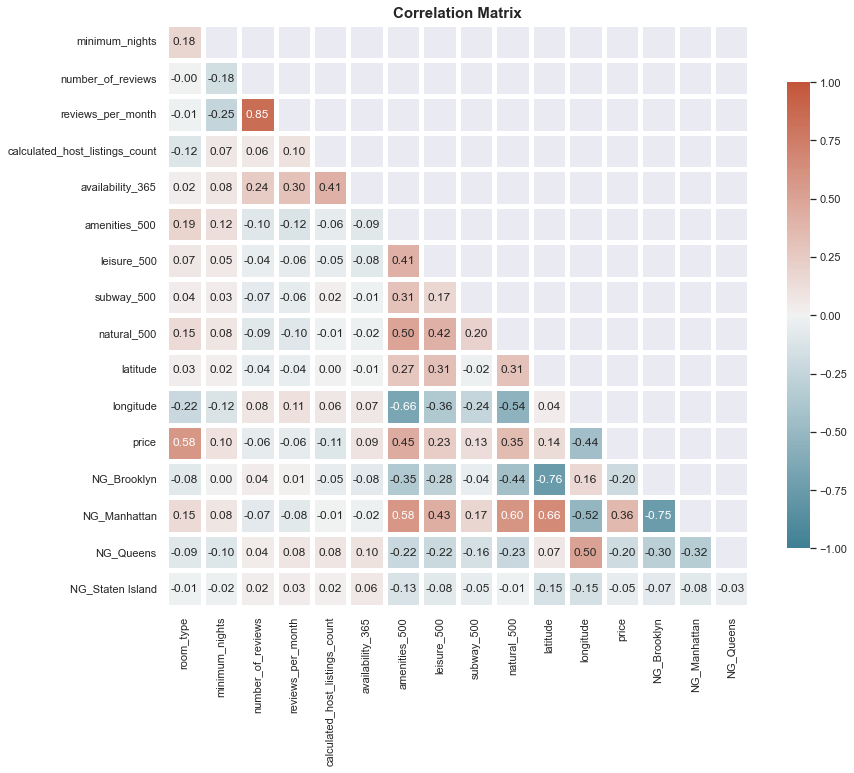

In [21]:
corr_cinc = df_to_explore.corr('spearman')
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_cinc, dtype=np.bool))# adjust mask and df
mask = mask[1:, :-1]
corr = corr_cinc.iloc[1:,:-1].copy()# color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)# ticks
plt.title("Correlation Matrix", size = 15, weight = 'bold')
plt.show()


In [22]:

fig = px.box(df_concat, y='price', points='all', hover_data=['price'], color='neighbourhood_group')
fig.show()

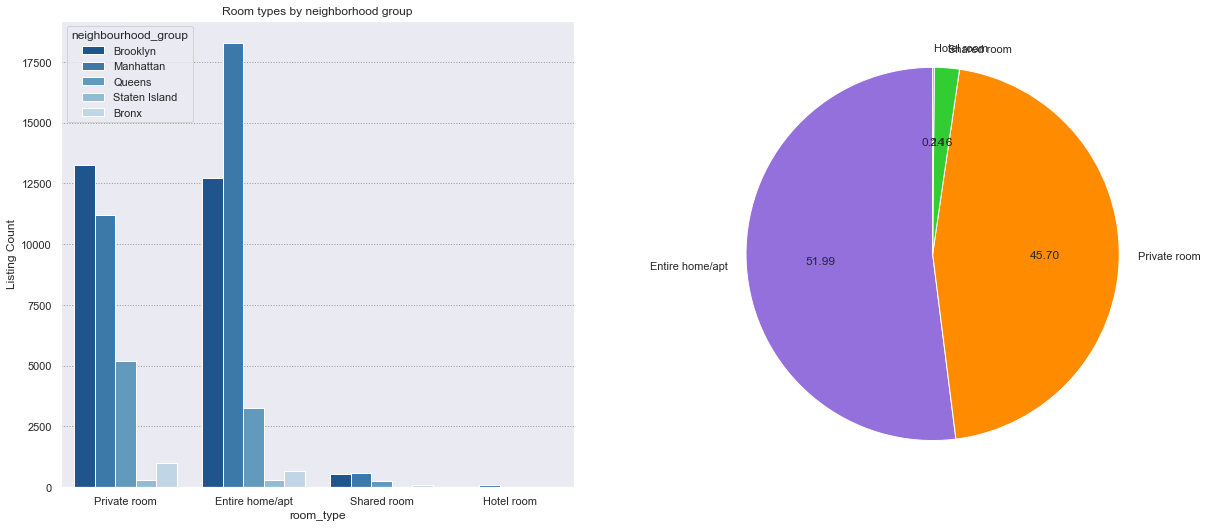

In [23]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
f,ax=plt.subplots(1,2,figsize=(18,8))
colors = ['mediumpurple','darkorange','limegreen']
df_concat['room_type'].value_counts().plot(kind = 'pie', ax=ax[1],startangle=90,  label = "", colors=colors,autopct='%.2f')
sns.countplot(x = 'room_type',hue = "neighbourhood_group",data = df_concat, ax= ax[0])
ax[0].set_ylabel('Listing Count')
ax[0].set_title('Room types by neighborhood group')
ax[1].set_title('')
plt.show()

<function matplotlib.pyplot.ioff()>

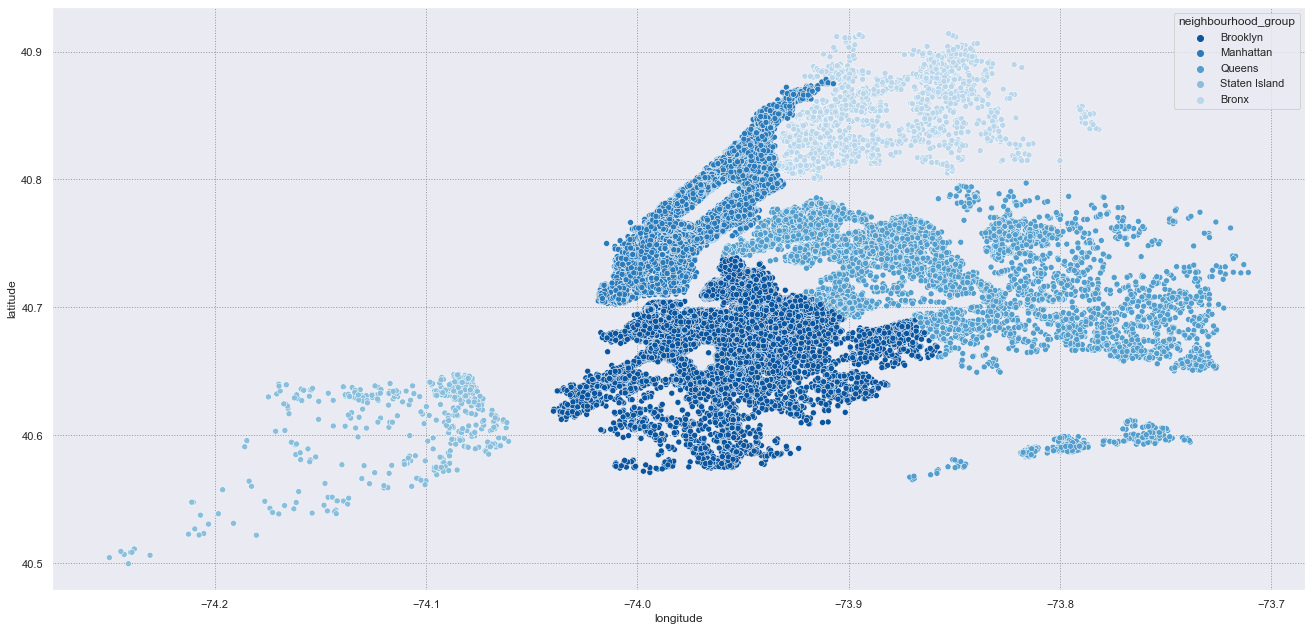

In [24]:
#plotting data
plt.figure(figsize=(20,10))
sns.scatterplot(df_concat.longitude, df_concat.latitude, hue = df_concat.neighbourhood_group)
plt.ioff

## Split data



In [26]:
from sklearn.model_selection import train_test_split

In [27]:
df_standardized = df_std.copy(deep=True)
y_transformed= df_standardized['price']
X_transformed= df_standardized.drop(['price','name','id'], axis=1)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_transformed, y_transformed, test_size=0.2, random_state=42)
train_df_transformed = pd.concat([X_train_t, y_train_t], axis=1)
test_df_transformed = pd.concat([X_test_t, y_test_t], axis=1)


In [28]:
X = df_all.drop(['price','name','id','latitude','longitude'], axis=1)
y = df_all['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [29]:
df_all.shape

(48800, 19)

In [30]:
filename_original = files_dir + "df_all_send.csv"
df_all.to_csv(filename_original, index=False)

In [31]:
df_all.columns

Index(['id', 'name', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'NG_Brooklyn',
       'NG_Manhattan', 'NG_Queens', 'NG_Staten Island', 'amenities_500',
       'leisure_500', 'subway_500', 'natural_500'],
      dtype='object')

## Benchmarking models

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBRegressor

In [33]:

linreg=LinearRegression()
tt = TransformedTargetRegressor(regressor=linreg,
                                 func=np.log1p, inverse_func=np.expm1)
tt.fit(X_train_t,y_train_t)
y_pred=tt.predict(X_test_t)
y_pred_invtransformed = np.expm1(y_pred)
y_test_invtransformed = np.expm1(y_test_t)
r2=r2_score(y_test_invtransformed ,y_pred_invtransformed )
rmse_score=np.sqrt(mean_squared_error(y_test_invtransformed ,y_pred_invtransformed ))
print(f'RMSE score : {rmse_score}')
print(f'R2 score : {r2}')


RMSE score : 90.32430419064795
R2 score : 0.21579543240401144


In [29]:


dt=DecisionTreeRegressor(min_samples_leaf=.0001)
tt = TransformedTargetRegressor(regressor=dt,
                                 func=np.log1p, inverse_func=np.expm1)
tt.fit(X_train_t,y_train_t)
y_pred=tt.predict(X_test_t)

y_pred_invtransformed = np.expm1(y_pred)
y_test_invtransformed = np.expm1(y_test_t)
r2=r2_score(y_test_invtransformed ,y_pred_invtransformed )
rmse_score=np.sqrt(mean_squared_error(y_test_invtransformed ,y_pred_invtransformed ))
print(f'RMSE score : {rmse_score}')
print(f'R2 score : {r2}')

RMSE score : 85.59845397440438
R2 score : 0.2957092901617592


In [30]:
#Random forest regression 

regrRM2 = RandomForestRegressor(n_estimators=200, max_depth = 50, min_samples_split = 5,min_samples_leaf =4)
regrRM2.fit(X_train_t, y_train_t)
y_pred=regrRM2.predict(X_test_t)
y_pred_invtransformed = np.expm1(y_pred)
y_test_invtransformed = np.expm1(y_test_t)
r2=r2_score(y_test_invtransformed ,y_pred_invtransformed )
rmse_score=np.sqrt(mean_squared_error(y_test_invtransformed ,y_pred_invtransformed ))
print(f'RMSE score : {rmse_score}')
print(f'R2 score : {r2}')

RMSE score : 72.24618857981524
R2 score : 0.49829318665309885


In [31]:

xgboost_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4, random_state=42, max_depth = 8)
pipe = TransformedTargetRegressor(regressor=xgboost_model,
                                 func=np.log1p, inverse_func=np.expm1)
pipe.fit(X_train_t, y_train_t, 
             early_stopping_rounds=5, 
             eval_set=[(X_test_t, y_test_t)], 
             verbose=False)
y_pred = pipe.predict(X_test_t)
y_pred_invtransformed = np.expm1(y_pred)
y_test_invtransformed = np.expm1(y_test_t)
r2=r2_score(y_test_invtransformed ,y_pred_invtransformed )
rmse_score=np.sqrt(mean_squared_error(y_test_invtransformed ,y_pred_invtransformed ))
print(f'RMSE score : {rmse_score}')
print(f'R2 score : {r2}')

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE score : 72.5137211481754
R2 score : 0.4945705977308157


In [33]:

xgboost_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4, random_state=42, max_depth = 8)
pipe = TransformedTargetRegressor(regressor=xgboost_model,
                                 func=np.log1p, inverse_func=np.expm1)
pipe.fit(X_train_t[selected_feat_lgb], y_train_t, 
             early_stopping_rounds=5, 
             eval_set=[(X_test_t[selected_feat_lgb], y_test_t)], 
             verbose=False)
y_pred = pipe.predict(X_test_t[selected_feat_lgb])
y_pred_invtransformed = np.expm1(y_pred)
y_test_invtransformed = np.expm1(y_test_t)
r2=r2_score(y_test_invtransformed ,y_pred_invtransformed )
rmse_score=np.sqrt(mean_squared_error(y_test_invtransformed ,y_pred_invtransformed ))
print(f'RMSE score : {rmse_score}')
print(f'R2 score : {r2}')

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE score : 72.77573551698134
R2 score : 0.4909114552005327


/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [34]:


scaler = StandardScaler()
transformer = FunctionTransformer(np.log1p)
xgb_pipe = Pipeline(steps=[('transformer', transformer), ('regressor', xgboost_model)])
xgb_pipe.fit(X_train_t, y_train_t)
y_pred = xgb_pipe.predict(X_test_t)
y_pred_invtransformed = np.expm1(y_pred)
y_test_invtransformed = np.expm1(y_test_t)
r2=r2_score(y_test_invtransformed ,y_pred_invtransformed )
rmse_score=np.sqrt(mean_squared_error(y_test_invtransformed ,y_pred_invtransformed ))
print(f'RMSE score : {rmse_score}')
print(f'R2 score : {r2}')

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE score : 72.58623799690994
R2 score : 0.49355918985396485


In [35]:
scaler = StandardScaler()
transformer = FunctionTransformer(np.log1p)
xgb_pipe = Pipeline(steps=[('transformer', transformer), ('regressor', xgboost_model)])
xgb_pipe.fit(X_train_t[selected_feat_lgb], y_train_t)
y_pred = xgb_pipe.predict(X_test_t[selected_feat_lgb])
y_pred_invtransformed = np.expm1(y_pred)
y_test_invtransformed = np.expm1(y_test_t)
r2=r2_score(y_test_invtransformed ,y_pred_invtransformed )
rmse_score=np.sqrt(mean_squared_error(y_test_invtransformed ,y_pred_invtransformed ))
print(f'RMSE score : {rmse_score}')
print(f'R2 score : {r2}')

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE score : 73.45421273876063
R2 score : 0.4813748958415257


/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


## Model Selection

In [ ]:
estimator_xgb_selected= XGBRegressor(num_leaves = 11, max_depth =  6, feature_fraction = 0.7855246439257477, learning_rate = 0.25056586961086624)
rfe = RFE(estimator_xgb_selected, n_features_to_select=  10)
rfe.fit(X_train_t, y_train_t)
selected_feat_lgb = []
for i in range(X_train_t.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (X_train_t.columns[i], rfe.support_[i], rfe.ranking_[i]))
    if rfe.support_[i] == True: 
        selected_feat_lgb.append(X_train_t.columns[i])   
selected_feat_lgb

## Optimizing the Hyperparameters

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
# optimization
import optuna
from optuna.samplers import  TPESampler

In [62]:
def objective_function(trial,X,y):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2,random_state=42)
    param = {
        'num_leaves': trial.suggest_int( 'num_leaves', 8 , 20),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'feature_fraction': trial.suggest_loguniform('feature_fraction', 0.7,0.9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.2,0.5),
        'n_estimators': 4000
    }
    model = XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=10,verbose=False)
    
    preds = model.predict(test_x)
    trans_preds = np.expm1(preds)
    trans_tests = np.expm1(test_y)
    rmse = mean_squared_error(trans_tests, trans_preds,squared=False)
    return rmse

In [64]:
# study = optuna.create_study(sampler=TPESampler(seed=42))
# study.optimize(
#     lambda trial: objective_function(
#         trial=trial,
#         X = X_train_t[selected_feat_lgb],
#         y = y_train_t,
#     )    
# )
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

## CV Evalutation


In [43]:
estimator_xgb_selected= XGBRegressor(num_leaves = 14, max_depth =  7, feature_fraction = 0.7402283829232867, learning_rate = 0.24846947488119883)

In [44]:
import time
# Sklearn Models and Evaluation
from sklearn import metrics, utils
from sklearn.dummy import  DummyRegressor
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
def cross_validation_report_reg(X,y, model, model_name,  scale = False, log_transform = False):
    kf =KFold(n_splits=10, random_state=rs, shuffle = True)
    # define X and y
    y = y.values
    X = X.values
    X, y = utils.shuffle(X, y, random_state=rs)
    mae_scores = []
    mse_scores = []

    r2_scores = []
    adjusted_r2 = []
    rmse_scores = []
    if log_transform == True:
        model = TransformedTargetRegressor(regressor=model,                  
        func=np.log1p, inverse_func=np.expm1)
    st = time.time()
    for train_index, test_index in kf.split(X):
    # Split train-test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
      #Scale
        if scale == True:
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        model = model.fit(X_train, y_train)
        # Append scores
        y_pred = model.predict(X_test)

        r2_scores.append(metrics.r2_score(y_test,y_pred))
        adjusted_r2.append(1 - (1-metrics.r2_score(y_test,y_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
        )
        rmse_scores.append(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
        mae_scores.append(metrics.mean_absolute_error(y_test,y_pred))
        mse_scores.append(metrics.mean_squared_error(y_test,y_pred))
    
    end = time.time()
    measured_time = end-st
    print('Process Complete in : '+str(measured_time)+' sec.')
    print(f'Model: {model_name}')
    print(f' R2 : {np.average(r2_scores)}')
    print(f'Adjusted R2: {np.average(adjusted_r2)}')
    print(f' MAE : {np.average(mae_scores)}')
    print(f' MSE : {np.average(mse_scores)}')
    print(f'RMSE: {np.average(rmse_scores)}')
    return mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name

In [45]:
regressors = {}
mae_results = {}
mse_results = {}
r2_results = {}
r2_adj = {}
rmse = {}
reg_time = {}
regressors['r2'] = r2_results
regressors['r2_adj'] = r2_adj
regressors['rmse'] = rmse
regressors['mae'] = mae_results
regressors['mse'] = mse_results
regressors['time'] = reg_time
regressors

{'r2': {}, 'r2_adj': {}, 'rmse': {}, 'mae': {}, 'mse': {}, 'time': {}}

In [46]:
X.shape

(48800, 14)

In [47]:
y.shape

(48800,)

In [48]:
name = 'Dummy Regressor'
dummy = DummyRegressor( strategy = 'mean')
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X
                                                                                                        ,y,dummy,
                                                                                                        model_name = name, 
                                                                                                        scale = True,
                                                                                                        log_transform = True)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 0.18741083145141602 sec.
Model: Dummy Regressor
 R2 : -0.07390560031733981
Adjusted R2: -0.07699597614559113
 MAE : 70.87620792098437
 MSE : 11200.805801193264
RMSE: 105.81765956396472


In [49]:
name = 'KNN Regressor'
knnregressor = KNeighborsRegressor(n_neighbors=5)
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X
                                                                                                        ,y,knnregressor,
                                                                                                        model_name = name, 
                                                                                                        scale = True,
                                                                                                        log_transform = True)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 10.085827827453613 sec.
Model: KNN Regressor
 R2 : 0.41636254725226535
Adjusted R2: 0.41468301501414234
 MAE : 47.99565037038569
 MSE : 6086.697517405519
RMSE: 78.00085616483754


In [50]:
name = 'RFRegressor'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X,
                                                                                                        y,regrRM2, 
                                                                                                        model_name = name, 
                                                                                                        scale = True, 
                                                                                                        log_transform = True)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

KeyboardInterrupt: 

In [ ]:
name = 'XBoost w/o Selected Features'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X,
                                                                                                        y,estimator_xgb_selected, 
                                                                                                        model_name = name, 
                                                                                                        scale = True, 
                                                                                                        log_transform = True)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

[11:12:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "feature_fraction", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:12:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "feature_fraction", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:12:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "feature_fraction", "num_leaves" } might not be used.

  This could be a false alarm

In [ ]:
name = 'XBoost w/ Selected Features'
X_selected = X[selected_feat_lgb]
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_selected,
                                                                                                        y,estimator_xgb_selected, 
                                                                                                        model_name = name, 
                                                                                                        scale = True, 
                                                                                                        log_transform = True)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

[18:06:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "feature_fraction", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:06:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "feature_fraction", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:06:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "feature_fraction", "num_leaves" } might not be used.

  This could be a false alarm

## Exporting final model


/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:12:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "feature_fraction", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             feature_fraction=0.7855246439257477, gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.25056586961086624, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_leaves=11, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
X_test.iloc[0,:]

room_type                           1.0
minimum_nights                     30.0
number_of_reviews                   0.0
reviews_per_month                   0.0
calculated_host_listings_count      2.0
availability_365                  249.0
NG_Brooklyn                         0.0
NG_Manhattan                        1.0
NG_Queens                           0.0
NG_Staten Island                    0.0
amenities_500                     148.0
leisure_500                         9.0
subway_500                          0.0
natural_500                         1.0
Name: 37062, dtype: float64

In [72]:
scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X)
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))
# saving the model 
#fit the model
estimator_xgb_selected.fit(X,y)
pickle_out = open("model_regressor.pkl", mode = "wb") 
pickle.dump(estimator_xgb_selected, pickle_out) 
pickle_out.close()

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[15:14:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "feature_fraction", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [135]:
X_scaled = pd.DataFrame(scaler.transform(X_test.iloc[0:5,:]),columns = X_test.columns)


/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [138]:
estimator_xgb_selected.predict(X_scaled)

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


array([249.48303 ,  59.745598, 172.1342  ,  47.91668 ,  66.92838 ],
      dtype=float32)

## Explaining the results

In [64]:
import shap
import xgboost
import sklearn
# Using a random sample of the dataframe for better time computation
X_s = train_df.drop(['price'], axis=1)
y_s = train_df['price']
X_st = test_df.drop(['price'], axis=1)
y_st = test_df['price']
X_sampled = X_s.sample(1000, random_state=10)
X_sampled

,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,NG_Brooklyn,NG_Manhattan,NG_Queens,NG_Staten Island,amenities_500,leisure_500,subway_500,natural_500
17757,1,1,0,0.00,1,0,1,0,0,0,2,1,0,0
2154,1,30,4,0.08,8,346,0,1,0,0,72,7,0,1
37924,0,2,3,0.40,2,105,0,0,1,0,0,2,0,0
46844,1,2,0,0.00,1,245,0,1,0,0,139,5,0,1
15266,0,2,0,0.00,1,0,1,0,0,0,45,18,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26162,1,5,40,1.84,1,88,1,0,0,0,51,5,0,1
28004,1,1,61,3.23,1,0,1,0,0,0,70,5,0,2
5622,1,5,14,0.28,2,363,1,0,0,0,16,2,1,0
43525,0,7,0,0.00,1,0,1,0,0,0,17,3,0,0


In [65]:
estimator_xgb_selected.fit(X_s, y_s, 
             early_stopping_rounds=5, 
             eval_set=[(X_st, y_st)], 
             verbose=False)
explainer = shap.TreeExplainer(estimator_xgb_selected)
shap_values = explainer.shap_values(X_sampled)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[14:40:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "feature_fraction", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




ntree_limit is deprecated, use `iteration_range` or model slicing instead.


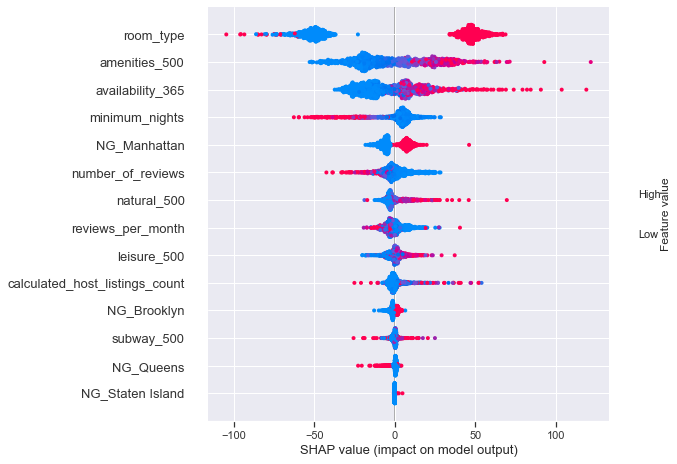

In [66]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled)

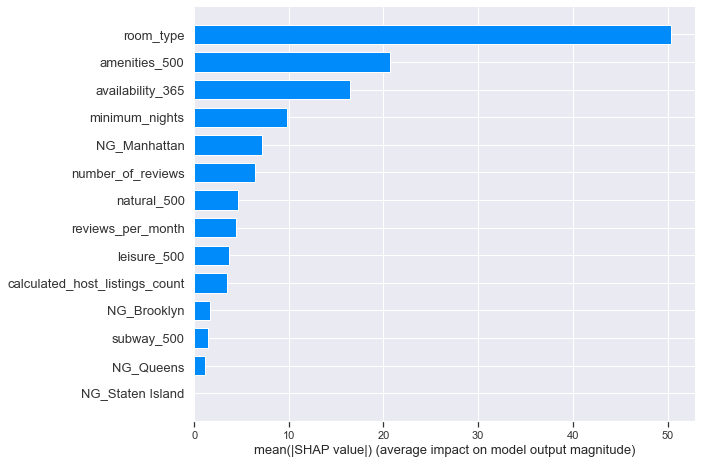

In [67]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

## Condifence Intervals with GB Quantile Regression


In [68]:
estimator_xgb_selected

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             feature_fraction=0.7402283829232867, gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.24846947488119883, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_leaves=14, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [69]:
# left and right quantiles used to estimate confidence
alpha_qleft = 0.2
alpha_qright = 0.8

import lightgbm as lgb
# model hyperparams
model_params = {
    'objective':'quantile',
    'metric':'quantile',
    'max_depth': 6,
    'num_leaves': 11,
    'min_data_in_leaf': 15,
    'learning_rate': 0.25056586961086624,
    'feature_fraction':0.7855246439257477,
    'seed':rs,
}

model_params["alpha"] = alpha_qright
    
train_df_kwargs = {
    "data":train_df.drop(['price'], axis=1),
    "free_raw_data":False,
    "label":train_df.price.values
}
_train_data = lgb.Dataset(**train_df_kwargs)

valid_df_kwargs = {
    "data":test_df.drop(['price'], axis=1),
    "free_raw_data":False,
    "label":test_df.price.values
}
_valid_data = lgb.Dataset(**valid_df_kwargs)


training_kwargs = {
    "train_set": _train_data,
    "valid_sets": _valid_data,
    "early_stopping_rounds": 250,
    "num_boost_round": 1000,
    "params": model_params,
    "verbose_eval":50,
}

model_right = lgb.train(**training_kwargs)
model_params["alpha"] = alpha_qleft
model_left = lgb.train(**training_kwargs)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 39040, number of used features: 14
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 200.000000
Training until validation scores don't improve for 250 rounds
[50]	valid_0's quantile: 20.649
[100]	valid_0's quantile: 20.5176
[150]	valid_0's quantile: 20.433
[200]	valid_0's quantile: 20.3927
[250]	valid_0's quantile: 20.3856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's quantile: 20.3873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	valid_0's quantile: 20.3474
[LightGBM] [Warning] No further splits with po

In [165]:
model_right.predict(X_test)

array([304.01850185,  75.52842031, 218.12312775, ..., 132.13438139,
        72.41872624,  76.48298617])

In [166]:
model_left.predict(X_test)

array([136.23920977,  37.69549826, 137.30639513, ...,  81.47056531,
        49.20774173,  45.20743503])

In [167]:
estimator_xgb_selected.predict(X_test)

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


array([249.48303 ,  59.745598, 172.1342  , ..., 100.06982 ,  69.011826,
        57.676132], dtype=float32)

In [70]:
# saving the model 
pickle_out = open("model_regressor_uq.pkl", mode = "wb") 
pickle.dump(model_right, pickle_out) 
pickle_out.close()

In [71]:
pickle_out = open("model_regressor_lq.pkl", mode = "wb") 
pickle.dump(model_left, pickle_out) 
pickle_out.close()